In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import Counter
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib2

In [2]:
def state_enrichment(ideas, boundary):
    pos1 = boundary
    pos1 = pos1.astype(int)
    ideas1 = ideas[pos1,:]
    return ideas1.sum(axis=0)

In [3]:
def domainlevel(domain,ll):
        domain=domain.astype(int)
        for o in range(0,np.shape(domain)[0]):
                for p in range(domain[o,0],(domain[o,1]+1)):
                        ll[p]+=1
        return ll

In [4]:
def getlevel(tads):
    ftads = tads[(tads[:,1]-tads[:,0]).argsort()[::-1],:]
    rtads = tads[(tads[:,1]-tads[:,0]).argsort(),:]
    flevel = np.ones(len(tads))
    rlevel = np.ones(len(tads))
    for i in range(0,len(tads)):
        rn = []
        fn = []
        for j in range(0,i):
            if rtads[i,0]<=rtads[j,0] and rtads[i,1]>=rtads[j,1]:
                rn.append(rlevel[j])
            if ftads[i,0]>=ftads[j,0] and ftads[i,1]<=ftads[j,1]:
                fn.append(flevel[j])
        if len(rn)>=1:
            rlevel[i] = max(rn)+1
        if len(fn)>=1:
            flevel[i] = max(fn)+1
    return (np.column_stack((ftads,flevel,rlevel[::-1])))

def boundarylevel(tad):
    leftb,leftl = np.unique(tad[:,0],return_counts=True)
    rightb, rightl = np.unique(tad[:,1],return_counts=True)
    allb = np.copy(leftb)
    alll = np.copy(leftl)
    for i in range(0,len(rightb)):
        ind = np.where(leftb==rightb[i])[0]
        if len(ind) > 0:
            if rightl[i]>leftl[ind[0]]:
                alll[ind[0]]=rightl[i]
        else:
            allb=np.append(allb,rightb[i])
            alll=np.append(alll,rightl[i])
    return (allb,alll)

In [47]:
#####Calculate Background Percentage####
celltype = 'Gm12878'
resn='10kb'
res = 10000

ideasfinal = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/data/'+celltype+'_IDEAS36'),delimiter='\t')
name = ideasfinal['name'].values
nbin = (ideasfinal['chromEnd'].values - ideasfinal['chromStart'].values+1)/200
d = Counter(list(ideasfinal['name'].values))
for i in range(0,len(nbin)):
    d[name[i]]+=(nbin[i]-1)
background = {}
for n in d.keys():
    background[n] = d[n] / float(sum(nbin))
######Calculate countmat for each chr######
statedict = dict()
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
for i in range(len(background.keys())):
    statedict[background.keys()[i]] = i
print background.keys()


['LowReprW', 'CtcfO', 'Enh', 'TssW', 'Gen5', 'Repr2', 'Gen3', 'Repr1', 'TssF', 'PromP', 'EnhWF2', 'EnhWF3', 'EnhWF1', 'Tss', 'Ctcf', 'EnhF', 'Pol2', 'ElonW', 'Gen3Ctcf', 'FaireW1', 'FaireW2', 'EnhW', 'DnaseD1', 'DnaseD2', 'PromF2', 'PromF1', 'Art1', 'Art2', 'Quies', 'Zero', 'Low2', 'Low1', 'Elon', 'ReprD', 'TssCtcf', 'PromCtcf']


In [48]:
DPrawexpo1 = np.array([0.0]*len(background.keys()))
DPrawexpo2 = np.array([0.0]*len(background.keys()))
DPrawexpo3 = np.array([0.0]*len(background.keys()))
DPrawexpo4 = np.array([0.0]*len(background.keys()))
DPrawexpo5 = np.array([0.0]*len(background.keys()))
DPrawexposolo = np.array([0.0]*len(background.keys()))

DPrawexp1 = np.array([0.0]*len(background.keys()))
DPrawexp2 = np.array([0.0]*len(background.keys()))
DPrawexp3 = np.array([0.0]*len(background.keys()))
DPrawexp4 = np.array([0.0]*len(background.keys()))
DPrawexp5 = np.array([0.0]*len(background.keys()))
DPrawexpsolo = np.array([0.0]*len(background.keys()))
DPrawexpnob = np.array([0.0]*len(background.keys()))

DPrawl1b = 0
DPrawl2b = 0
DPrawl3b = 0
DPrawl4b = 0
DPrawl5b = 0

In [49]:
for chrnum in range(1,23):
        for chrnb in range(chrnum,chrnum+1):
            chrlength = chrs_length[chrnb-1]
            chrnumfull='chr'+str(chrnb)
            chromfinal = ideasfinal.loc[ideasfinal['chrom']==chrnumfull,['chrom','chromStart','chromEnd','name']].values
            mat = np.zeros(shape=(chrlength/res+1,len(background.keys())))
            for ideasrow in range(0,np.shape(chromfinal)[0]):
                for pos in range(int(chromfinal[ideasrow,1]),int(chromfinal[ideasrow,2])+1,200):
                    rownum = pos / res
                    state = chromfinal[ideasrow,3]
                    mat[rownum,statedict[state]] += 1

        OnTAD_raw = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/'+celltype+'/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_rawa = OnTAD_raw.loc[(OnTAD_raw[2]>0),:].values[:,0:2]-1
        OnTAD_rawb = np.unique(OnTAD_rawa.flatten())   
        OnTAD_rawfr = getlevel(OnTAD_rawa)
        tadarea = np.asarray(domainlevel(OnTAD_rawa,[0]*(chrs_length[chrnum-1]/res+1)))
        OnTAD_rawsolo = OnTAD_rawfr[(OnTAD_rawfr[:,2]==1)&(OnTAD_rawfr[:,2]==1),0:2]
        soloarea = np.asarray(domainlevel(OnTAD_rawsolo,[0]*(chrs_length[chrnum-1]/res+1)))
        OnTAD_rawsoloa = np.intersect1d(np.where(tadarea==1)[0],np.where(soloarea==1)[0])
        OnTAD_raw1 = OnTAD_rawfr[(OnTAD_rawfr[:,2]==1)&(OnTAD_rawfr[:,3]>1),0:2]
        l1area = np.asarray(domainlevel(OnTAD_raw1,[0]*(chrs_length[chrnum-1]/res+1)))
        OnTAD_raw1a = np.intersect1d(np.where(tadarea==1)[0],np.where(l1area==1)[0])
        OnTAD_raw2a = np.where(tadarea==2)[0]
        OnTAD_raw3a = np.where(tadarea==3)[0]
        OnTAD_raw4a = np.where(tadarea==4)[0]
        OnTAD_raw5a = np.where(tadarea>=5)[0]

        OnTAD_rawnob = np.where(tadarea==0)[0]

        OnTAD_rawallb, OnTAD_rawalll = boundarylevel(OnTAD_rawfr)
        OnTAD_rawo1b = OnTAD_rawallb[OnTAD_rawalll==1]
        OnTAD_rawo2b = OnTAD_rawallb[OnTAD_rawalll==2]
        OnTAD_rawo3b = OnTAD_rawallb[OnTAD_rawalll==3]
        OnTAD_rawo4b = OnTAD_rawallb[OnTAD_rawalll==4]
        OnTAD_rawo5b = OnTAD_rawallb[OnTAD_rawalll>=5]
        OnTAD_rawsolob = np.intersect1d(np.unique(OnTAD_rawsoloa.flatten()), OnTAD_rawo1b)

        DPrawexpo1 += state_enrichment(mat, OnTAD_rawo1b)
        DPrawexpo2 += state_enrichment(mat, OnTAD_rawo2b)
        DPrawexpo3 += state_enrichment(mat, OnTAD_rawo3b)
        DPrawexpo4 += state_enrichment(mat, OnTAD_rawo4b)
        DPrawexpo5 += state_enrichment(mat, OnTAD_rawo5b)
        DPrawexposolo += state_enrichment(mat, OnTAD_rawsolob)

        DPrawl1b += len(OnTAD_rawo1b)
        DPrawl2b += len(OnTAD_rawo2b)
        DPrawl3b += len(OnTAD_rawo3b)
        DPrawl4b += len(OnTAD_rawo4b)
        DPrawl5b += len(OnTAD_rawo5b)
        
        DPrawexp1 += state_enrichment(mat, OnTAD_raw1a)
        DPrawexp2 += state_enrichment(mat, OnTAD_raw2a)
        DPrawexp3 += state_enrichment(mat, OnTAD_raw3a)
        DPrawexp4 += state_enrichment(mat, OnTAD_raw4a)
        DPrawexp5 += state_enrichment(mat, OnTAD_raw5a)
        DPrawexpsolo += state_enrichment(mat, OnTAD_rawsoloa)
        DPrawexpnob += state_enrichment(mat, OnTAD_rawnob)
        

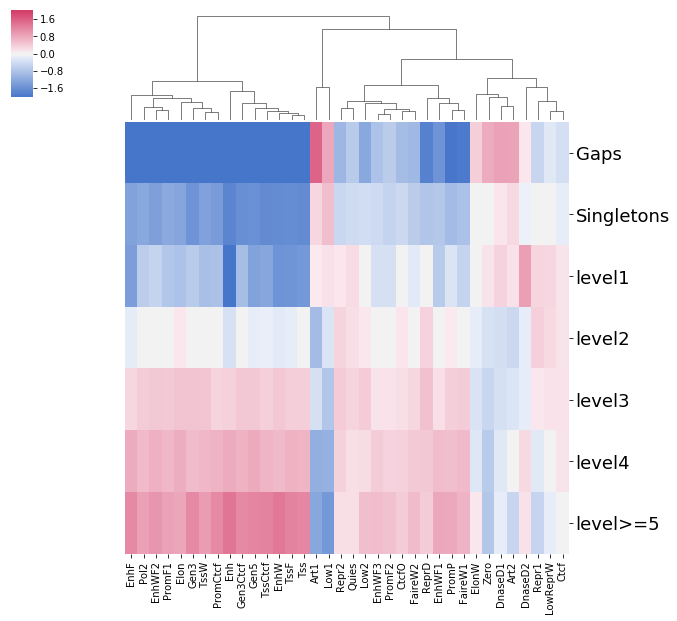

In [50]:
DPrawobs1 = np.array([background[k]*np.sum(DPrawexp1) for k in background.keys()])
DPrawobs2 = np.array([background[k]*np.sum(DPrawexp2) for k in background.keys()])
DPrawobs3 = np.array([background[k]*np.sum(DPrawexp3) for k in background.keys()])
DPrawobs4 = np.array([background[k]*np.sum(DPrawexp4) for k in background.keys()])
DPrawobs5 = np.array([background[k]*np.sum(DPrawexp5) for k in background.keys()])
DPrawobssolo = np.array([background[k]*np.sum(DPrawexpsolo) for k in background.keys()])
DPrawobsnob = np.array([background[k]*np.sum(DPrawexpnob) for k in background.keys()])

enrichmat = np.stack([(DPrawexpnob+1)/(DPrawobsnob+1),(DPrawexpsolo+1)/(DPrawobssolo+1),(DPrawexp1+1)/(DPrawobs1+1),(DPrawexp2+1)/(DPrawobs2+1),(DPrawexp3+1)/(DPrawobs3+1),(DPrawexp4+1)/(DPrawobs4+1),(DPrawexp5+1)/(DPrawobs5+1)], axis=0)

names=['Gaps','Singletons','level1','level2','level3','level4','level>=5']
cnames = ['LowReprW', 'CtcfO', 'Enh', 'TssW', 'Gen5', 'Repr2', 'Gen3', 'Repr1', 'TssF', 'PromP', 'EnhWF2', 'EnhWF3', 'EnhWF1', 'Tss', 'Ctcf', 'EnhF', 'Pol2', 'ElonW', 'Gen3Ctcf', 'FaireW1', 'FaireW2', 'EnhW', 'DnaseD1', 'DnaseD2', 'PromF2', 'PromF1', 'Art1', 'Art2', 'Quies', 'Zero', 'Low2', 'Low1', 'Elon', 'ReprD', 'TssCtcf', 'PromCtcf']
enrichmattable = pandas.DataFrame(data=np.log2(enrichmat+1e-6),columns=cnames,index=names)
g = sns.clustermap(enrichmattable,vmin=-2,vmax=2,row_cluster=False,cmap=sns.diverging_palette(255, 0,as_cmap = True))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=18) 
plt.savefig("/Users/linan/Desktop/IDEASatTAD_"+celltype+".png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

In [8]:
DPrawobso1 = np.array([background[k]*np.sum(DPrawexpo1) for k in background.keys()])
DPrawobso2 = np.array([background[k]*np.sum(DPrawexpo2) for k in background.keys()])
DPrawobso3 = np.array([background[k]*np.sum(DPrawexpo3) for k in background.keys()])
DPrawobso4 = np.array([background[k]*np.sum(DPrawexpo4) for k in background.keys()])
DPrawobso5 = np.array([background[k]*np.sum(DPrawexpo5) for k in background.keys()])
DPrawobsosolo = np.array([background[k]*np.sum(DPrawexposolo) for k in background.keys()])
DPrawobsnob = np.array([background[k]*np.sum(DPrawexpnob) for k in background.keys()])

enrichmatb = np.stack([(DPrawexpnob+1)/(DPrawobsnob+1),(DPrawexposolo+1)/(DPrawobsosolo+1),(DPrawexpo1+1)/(DPrawobso1+1),(DPrawexpo2+1)/(DPrawobso2+1),(DPrawexpo3+1)/(DPrawobso3+1),(DPrawexpo4+1)/(DPrawobso4+1),(DPrawexpo5+1)/(DPrawobso5+1)], axis=0)

names=['level1','level2','level3','level4','level>=5']
cnames = ['LowReprW', 'CtcfO', 'Enh', 'TssW', 'Gen5', 'Repr2', 'Gen3', 'Repr1', 'TssF', 'PromP', 'EnhWF2', 'EnhWF3', 'EnhWF1', 'Tss', 'Ctcf', 'EnhF', 'Pol2', 'ElonW', 'Gen3Ctcf', 'FaireW1', 'FaireW2', 'EnhW', 'DnaseD1', 'DnaseD2', 'PromF2', 'PromF1', 'Art1', 'Art2', 'Quies', 'Zero', 'Low2', 'Low1', 'Elon', 'ReprD', 'TssCtcf', 'PromCtcf']
enrichmattable = pandas.DataFrame(data=enrichmatb[2::,:],columns=cnames,index=names)
plt.figure(6)
g = sns.clustermap(enrichmattable,vmin=0,vmax=8,row_cluster=False,cmap="YlGnBu_r")#cmap=sns.diverging_palette(255, 0,as_cmap = True))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=18)
plt.savefig("/Users/linan/Desktop/IDEASatboundary.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

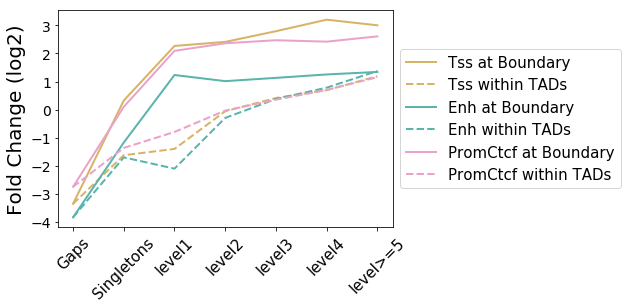

In [28]:
plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(np.log2(enrichmatb[:,13]+0.01),c='#d8b365',label='Tss at Boundary',linewidth=2)
ax.plot(np.log2(enrichmat[:,13]+0.01),c='#d8b365',label='Tss within TADs',linewidth=2,linestyle='--')
ax.plot(np.log2(enrichmatb[:,2]+0.01),c='#5ab4ac',label='Enh at Boundary',linewidth=2)
ax.plot(np.log2(enrichmat[:,2]+0.01),c='#5ab4ac',label='Enh within TADs',linewidth=2,linestyle='--')
ax.plot(np.log2(enrichmatb[:,35]+0.01),c='#e9a3c9',label='PromCtcf at Boundary',linewidth=2)
ax.plot(np.log2(enrichmat[:,35]+0.01),c='#e9a3c9',label='PromCtcf within TADs',linewidth=2,linestyle='--')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize = 15)
plt.ylabel('Fold Change (log2)', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,1,2,3,4,5,6),('Gaps','Singletons','level1','level2','level3','level4','level>=5'),color='k',size=15)
plt.xticks(rotation=45)
plt.savefig("/Users/linan/Desktop/IDEAS_lineplot.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

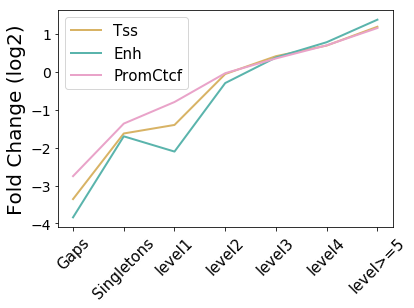

In [32]:
plt.figure(6)
fig,ax = plt.subplots(1)
ax.plot(np.log2(enrichmat[:,13]+0.01),c='#d8b365',label='Tss',linewidth=2)
ax.plot(np.log2(enrichmat[:,2]+0.01),c='#5ab4ac',label='Enh',linewidth=2)
ax.plot(np.log2(enrichmat[:,35]+0.01),c='#e9a3c9',label='PromCtcf',linewidth=2)
ax.legend(fontsize = 15)
plt.ylabel('Fold Change (log2)', {'color': 'k', 'fontsize': 20})
plt.yticks(color='k',size=14)
plt.xticks((0,1,2,3,4,5,6),('Gaps','Singletons','level1','level2','level3','level4','level>=5'),color='k',size=15)
plt.xticks(rotation=45)
plt.savefig("/Users/linan/Desktop/IDEAS_lineplot_TAD.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

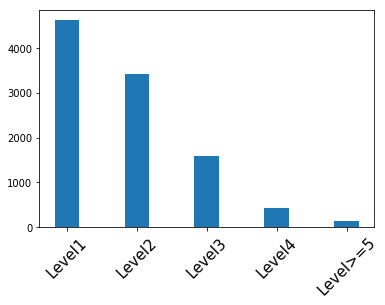

In [30]:
plt.figure(6)
fig,ax = plt.subplots(1)
ax.bar(np.arange(5),np.array([DPrawl1b, DPrawl2b, DPrawl3b, DPrawl4b, DPrawl5b]),0.35)
plt.xticks(np.arange(5), ('Level1','Level2','Level3','Level4','Level>=5'),size=15)

# Left Y-axis labels
#plt.ylabel('% covered by TAD', {'color': 'k', 'fontsize': 20})
#plt.yticks((0, 0.2, 0.4, 0.6, 0.8), ('0', '20%', '40%', '60%', '80%'), color='k',size=15)
plt.savefig("/Users/linan/Desktop/boundarycount.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.xticks(rotation=45)
plt.show()